In [1]:
import warnings
import os, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import lime
import lime.lime_tabular
import shap

from pipelines.functions import see_results, evaluate_metrics
from ml_injection_pipeline import prediction_pipeline
from tools.feed import data_info
from utils.config import DATASET_PATH, MODELS_PATH, MODEL_DATA_PATH

warnings.filterwarnings("ignore")

# Challenge 1: Regression model

![model_diagram](static/img/model_schema_xtreme.drawio.png)

<br />

The common and exclusive samples are based on the median price of the diamonds.

In [2]:
# DATA FEED
df = pd.read_csv(DATASET_PATH)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


In [3]:
df.table.unique()

array([55. , 56. , 58. , 57. , 54. , 57.2, 62. , 60. , 59. , 54.1, 64.2,
       61. , 70. , 53.8, 64. , 53. , 63. , 62.6, 54.5, 53.5, 52. , 56.3,
       57.6, 60.7, 54.9, 54.7, 55.4, 53.4, 55.3, 55.6, 95. , 65. , 53.9,
       68. , 55.2, 61.5, 61.9, 66. , 56.4, 59.7, 56.2, 59.3, 57.7, 53.7,
       60.5, 54.8, 61.7, 55.1, 67. , 59.2, 54.4, 60.8, 58.8, 60.4, 56.6,
       59.9, 53.6, 54.2, 62.2, 56.8, 60.1, 58.6, 62.5, 55.7, 65.4, 54.3,
       56.9, 59.4, 61.2, 56.7, 54.6, 57.1, 56.5, 51.6, 57.3, 60.6, 53.1,
       53.3])

In [4]:
# EXPLORATORY DATA ANALYSIS
data_info(df, sorted=True)

,index,columna,NaNs,pct_nan,dtype,count,count_unique,pct_unique
0,6,price,0,0.0,int64,5000,3179,63.58
1,5,table,0,0.0,float64,5000,78,1.56
2,4,depth,0,0.0,float64,5000,121,2.42
3,0,carat,0,0.0,float64,5000,202,4.04
4,9,z,0,0.0,float64,5000,304,6.08
5,8,y,0,0.0,float64,5000,471,9.42
6,7,x,0,0.0,float64,5000,474,9.48
7,1,cut,0,0.0,object,5000,5,0.10
8,2,color,0,0.0,object,5000,7,0.14
9,3,clarity,0,0.0,object,5000,8,0.16


In [5]:
# EXPLORATORY DATA ANALYSIS
df.describe()

,carat,depth,table,price,x,y,z
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,0.794486,61.711660,57.447060,3925.53940,5.725188,5.727744,3.533076
std,0.468424,1.446206,2.258999,3975.45212,1.119156,1.112106,0.690334
min,0.230000,44.000000,51.600000,-1.00000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,936.00000,4.700000,4.710000,2.900000
50%,0.700000,61.800000,57.000000,2392.50000,5.690000,5.700000,3.530000
75%,1.040000,62.500000,59.000000,5369.25000,6.540000,6.540000,4.030000
max,4.130000,70.200000,95.000000,18787.00000,10.000000,9.850000,6.430000


In [6]:
# REMOVE OUTLIERS
outlier_sample = df[(df.price <= 0) | (df["x"] <= 0) | (df["y"] <= 0) | (df["z"] <= 0)]
df = df[(df.price > 0) & (df["x"] > 0) & (df["y"] > 0) & (df["z"] > 0)].reset_index(drop=True)
display(outlier_sample)

,carat,cut,color,clarity,depth,table,price,x,y,z
331,1.00,Good,F,SI1,64.1,60.0,-1,6.25,6.19,3.99
2121,0.34,Ideal,E,VS2,59.8,56.0,-1,4.55,4.54,2.72
2484,1.75,Ideal,J,SI1,63.3,59.0,-1,7.63,7.57,4.81
2933,1.51,Ideal,H,VS2,62.5,55.0,-1,7.29,7.34,4.57
3155,0.31,Ideal,G,VS2,61.7,57.0,-1,4.33,4.36,2.68
3317,1.02,Premium,D,VS2,59.8,61.0,-1,6.61,6.54,3.93
3445,0.30,Premium,H,SI1,59.3,59.0,-1,4.38,4.36,2.59
3904,0.90,Very Good,G,SI2,64.2,56.0,-1,6.04,6.11,3.90
3980,0.41,Very Good,H,VS2,63.4,58.0,-1,4.77,4.66,2.99
4188,0.79,Ideal,H,VVS1,62.0,56.0,-1,5.92,5.96,3.68


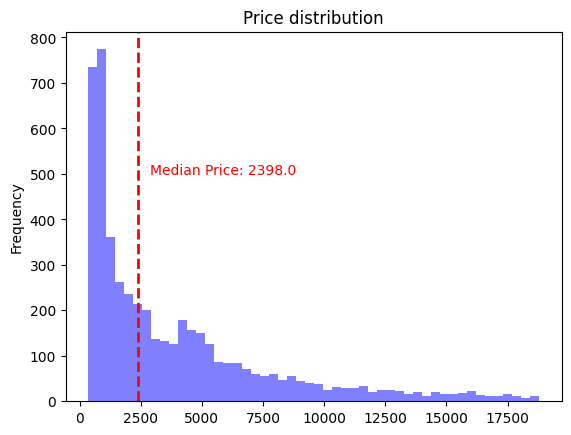

In [7]:
# Plot the histogram
df.price.plot.hist(bins=50, alpha=0.5, color='b', title='Price distribution')

# Add a vertical line at the median price value
median_price = df.price.median()
plt.axvline(median_price, color='r', linestyle='--', linewidth=2)

# Add text mentioning the median value
plt.text(median_price +500, 500, f"Median Price: {median_price}", color='r')

# Show the plot
plt.show()


In [8]:
# PRE CATEGORIZATION PROCESS USSING MEDIAN PRICE
exclusive_sample = df.loc[np.where(df.price >= df.price.median())[0], :]
common_sample = df.loc[np.where(df.price < df.price.median())[0], :]

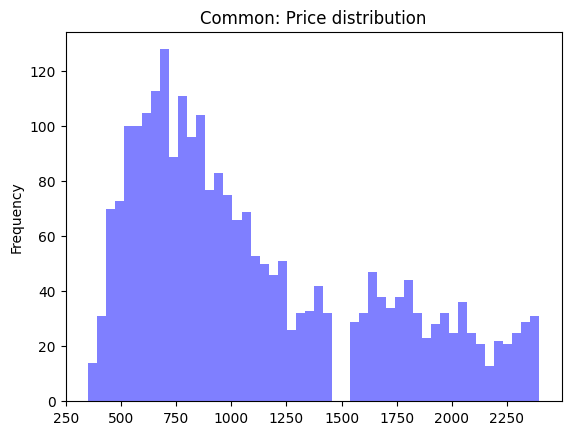

In [9]:
common_sample.price.plot.hist(bins=50, alpha=0.5, color='b', title='Common: Price distribution');

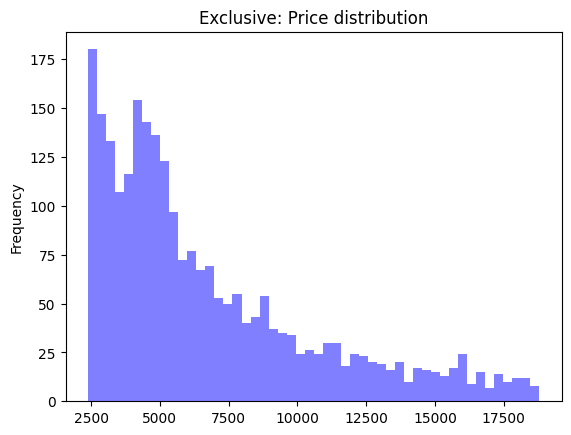

In [10]:
exclusive_sample.price.plot.hist(bins=50, alpha=0.5, color='b', title='Exclusive: Price distribution');

## 1st model: Logistic Regression

In [11]:
X_test = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'log_reg_X_test.csv'))
y_test = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'log_reg_y_cat_test.csv'))

with open(os.path.join(MODELS_PATH, 'log_reg.pkl'), 'rb') as f:
    log_reg = pickle.load(f)

display(X_test.head())
print('shape:', X_test.shape)

,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,2.575858,0.901561,-0.200897,2.084398,2.033043,2.201634,-0.177552,-0.315312,-0.811478,1.681494,...,-0.341073,4.377398,-0.110319,-0.162742,1.795644,-0.453116,-0.443040,-0.541060,-0.275701,-0.321989
1,0.681525,-2.022046,1.558796,0.895011,0.952899,0.636074,-0.177552,-0.315312,-0.811478,-0.594709,...,-0.341073,-0.228446,-0.110319,-0.162742,1.795644,-0.453116,-0.443040,-0.541060,-0.275701,-0.321989
2,-0.467846,-1.186730,-0.640820,-0.258605,-0.235260,-0.378641,-0.177552,-0.315312,1.232320,-0.594709,...,-0.341073,-0.228446,-0.110319,-0.162742,-0.556903,-0.453116,-0.443040,1.848223,-0.275701,-0.321989
3,-1.042532,-0.769072,-0.200897,-1.233366,-1.216391,-1.291884,-0.177552,-0.315312,1.232320,-0.594709,...,-0.341073,-0.228446,-0.110319,-0.162742,-0.556903,-0.453116,2.257135,-0.541060,-0.275701,-0.321989
4,-1.042532,0.205464,0.678949,-1.304908,-1.297402,-1.277388,-0.177552,-0.315312,-0.811478,-0.594709,...,-0.341073,-0.228446,-0.110319,-0.162742,-0.556903,-0.453116,2.257135,-0.541060,-0.275701,-0.321989


shape: (998, 26)


Train ROC AUC Score: 0.9988
Validation set confusion matrix


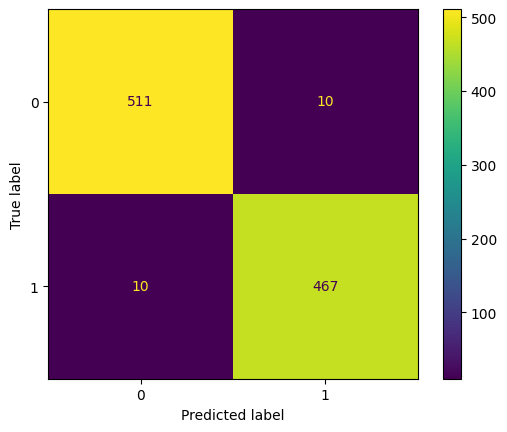

In [12]:
log_reg_train = log_reg.predict_proba(X_test)[:, 1]

# CATEGORIZATION MODEL EVALUATION
roc_auc_train = roc_auc_score(y_true=y_test, y_score=log_reg_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Confusion Matrix
threshold = 0.5
test_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=log_reg_train > threshold)
print("Validation set confusion matrix")
ConfusionMatrixDisplay(test_confusion_matrix).plot();

## 2nd model: LightGBM Common sample

Diamond with price under the median price.


In [13]:
Xc_val = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'common_Xc_val.csv'))
yc_val = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'common_yc_val.csv'))
Xc_test = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'common_Xc_test.csv'))
yc_test = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'common_yc_test.csv'))

with open(os.path.join(MODELS_PATH, 'lgbm_common.pkl'), 'rb') as f:
    lgbm_common = pickle.load(f)
    
display(Xc_val.head())
print('validation set shape:', Xc_val.shape)
print('test set shape:', Xc_test.shape)

,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-0.858804,0.228207,-0.027418,-0.862951,-0.947223,-0.857307,-0.12979,-0.315179,1.050469,-0.526235,...,-0.311314,-0.19225,-0.08413,-0.204551,-0.517670,-0.336855,-0.476026,1.891907,-0.34602,-0.385732
1,0.714047,-1.015749,-0.027418,0.895808,0.949975,0.704147,-0.12979,-0.315179,1.050469,-0.526235,...,-0.311314,-0.19225,-0.08413,-0.204551,-0.517670,-0.336855,2.100725,-0.528567,-0.34602,-0.385732
2,-0.184725,1.472162,-0.027418,-0.234823,-0.188344,0.093143,-0.12979,3.172801,-0.951956,-0.526235,...,-0.311314,-0.19225,-0.08413,-0.204551,1.931733,-0.336855,-0.476026,-0.528567,-0.34602,-0.385732
3,3.110772,2.171887,1.373030,2.382377,2.214774,2.842660,7.70478,-0.315179,-0.951956,-0.526235,...,-0.311314,-0.19225,-0.08413,-0.204551,-0.517670,2.968637,-0.476026,-0.528567,-0.34602,-0.385732
4,-0.783906,0.850185,-0.027418,-0.946701,-0.905063,-0.755473,-0.12979,-0.315179,-0.951956,-0.526235,...,-0.311314,-0.19225,-0.08413,-0.204551,-0.517670,-0.336855,-0.476026,1.891907,-0.34602,-0.385732


validation set shape: (497, 26)
test set shape: (5, 26)


R2 Score: 0.96 with Variance score: 0.96
MAE Score: 75.72
Max error: 388.74
(Total price of sample, Predicted total price, Difference)
561030 561512 482


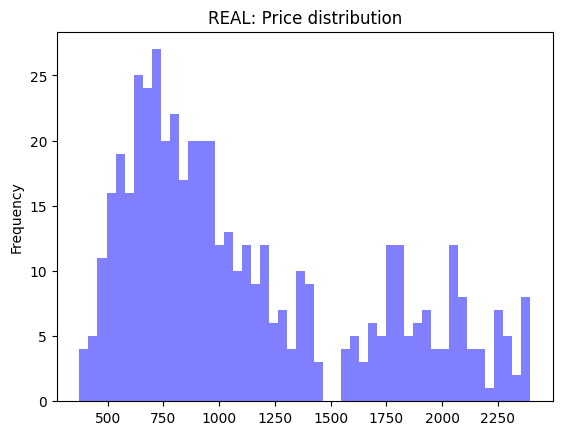

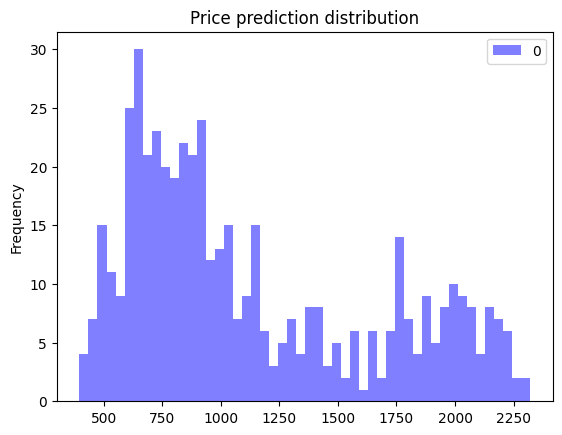

In [14]:
# MODEL PREDICTION AND EVALUATION
lgbm_pred_val = lgbm_common.predict(Xc_val)
lgbm_pred_test = lgbm_common.predict(Xc_test)

evaluate_metrics(yc_val, lgbm_pred_val)
see_results(yc_val, lgbm_pred_val)

R2 Score: 0.99 with Variance score: 0.99
MAE Score: 63.66
Max error: 139.86
(Total price of sample, Predicted total price, Difference)
5018 5100 82


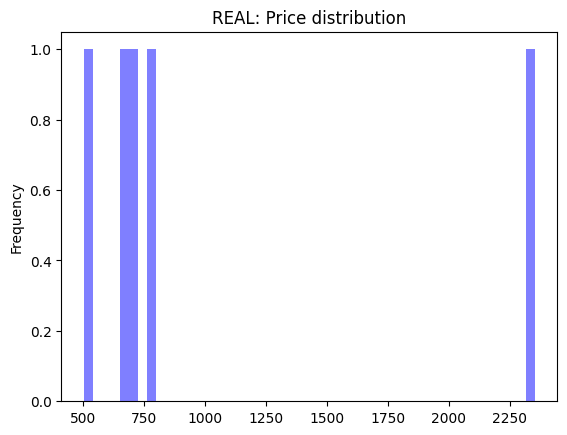

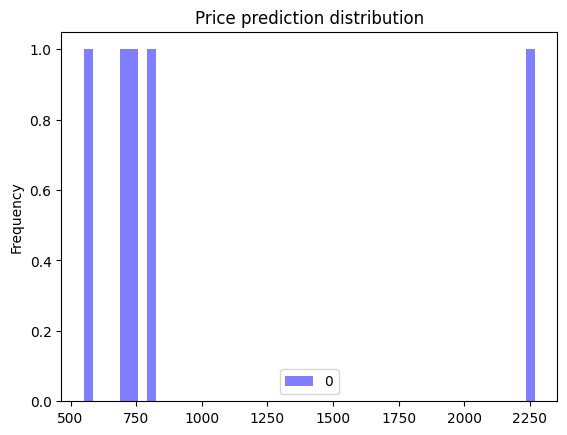

In [15]:
evaluate_metrics(yc_test, lgbm_pred_test)
see_results(yc_test, lgbm_pred_test)

## 3rd model: LightGBM Exclusive sample


In [16]:
Xe_val = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'exclusive_Xe_val.csv'))
ye_val = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'exclusive_ye_val.csv'))
Xe_test = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'exclusive_Xe_test.csv'))
ye_test = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'exclusive_ye_test.csv'))

with open(os.path.join(MODELS_PATH, 'lgbm_exclusive.pkl'), 'rb') as f:
    lgbm_exclusive = pickle.load(f)
    
display(Xe_val.head())
print('validation set shape:', Xe_val.shape)
print('test set shape:', Xe_test.shape)

,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-0.938835,-0.445477,-0.352166,-0.907182,-0.889317,-0.983344,-0.224958,-0.324623,-0.698078,-0.646140,...,-0.37525,-0.267405,-0.141277,-0.143113,-0.588746,1.792632,-0.410993,-0.539262,-0.186513,-0.257576
1,-1.015777,-2.368139,1.346449,-0.824364,-0.917293,-1.360523,-0.224958,3.080499,-0.698078,-0.646140,...,-0.37525,-0.267405,-0.141277,-0.143113,-0.588746,-0.557839,-0.410993,-0.539262,-0.186513,3.882342
2,0.856475,0.794950,0.497141,0.873406,0.789246,1.035678,-0.224958,-0.324623,-0.698078,1.547653,...,-0.37525,-0.267405,-0.141277,6.987489,-0.588746,-0.557839,-0.410993,-0.539262,-0.186513,-0.257576
3,0.163998,0.236758,-1.201474,0.335088,0.243713,0.347879,-0.224958,-0.324623,1.432504,-0.646140,...,-0.37525,-0.267405,-0.141277,-0.143113,-0.588746,1.792632,-0.410993,-0.539262,-0.186513,-0.257576
4,-0.400242,0.918993,-0.776820,-0.437880,-0.357772,-0.184610,-0.224958,-0.324623,1.432504,-0.646140,...,-0.37525,-0.267405,-0.141277,-0.143113,-0.588746,-0.557839,2.433134,-0.539262,-0.186513,-0.257576


validation set shape: (498, 26)
test set shape: (5, 26)


R2 Score: 0.95 with Variance score: 0.95
MAE Score: 561.53
Max error: 3884.09
(Total price of sample, Predicted total price, Difference)
3305031 3309196 4165


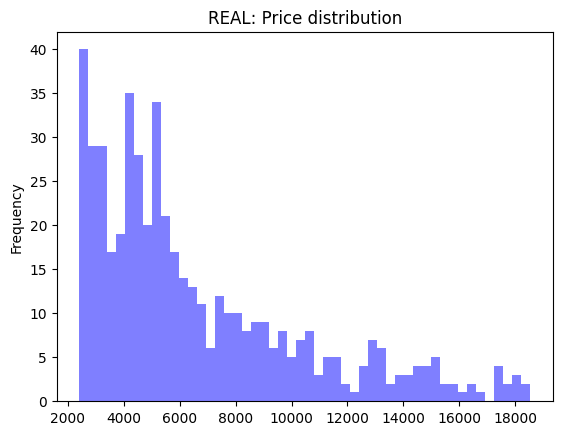

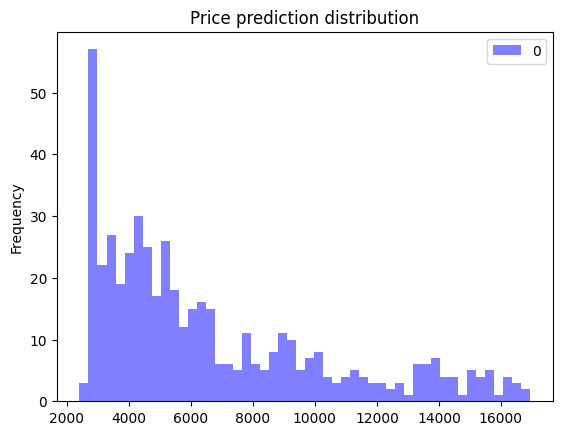

In [17]:
# MODEL PREDICTION
lgbm_pred_val = lgbm_exclusive.predict(Xe_val)
lgbm_pred_test = lgbm_exclusive.predict(Xe_test)

evaluate_metrics(ye_val, lgbm_pred_val)
see_results(ye_val, lgbm_pred_val)

R2 Score: 0.99 with Variance score: 0.99
MAE Score: 440.85
Max error: 790.99
(Total price of sample, Predicted total price, Difference)
32084 32894 810


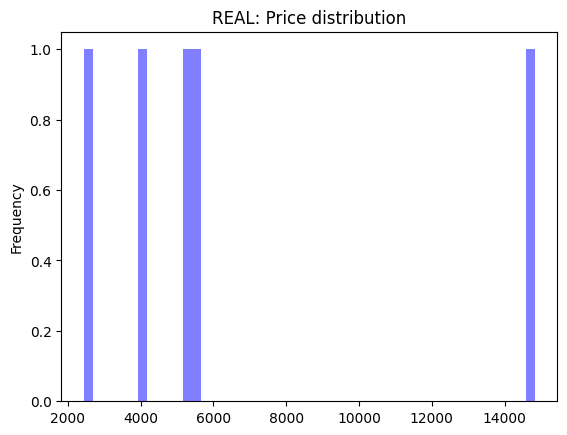

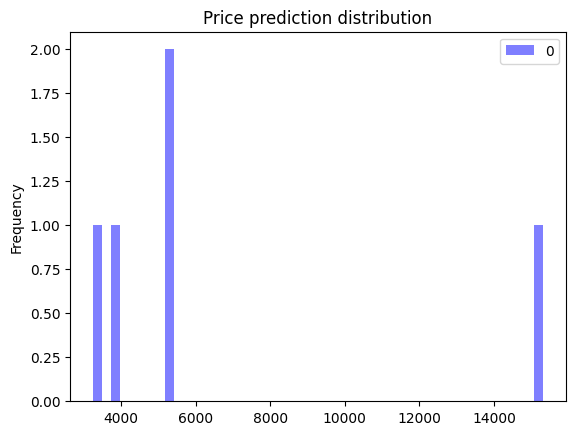

In [18]:
evaluate_metrics(ye_test, lgbm_pred_test)
see_results(ye_test, lgbm_pred_test)

# PREDICTIONS INTERPRETATION

In [19]:
# SELECT RANDOM SAMPLES
sample = df.sample(3)
sample_X = sample.drop(columns='price')
sample_y = sample.price
display(sample_X)
print(sample_y)

,carat,cut,color,clarity,depth,table,x,y,z
3213,0.30,Ideal,D,VS1,62.2,56.0,4.31,4.27,2.67
1361,0.79,Ideal,F,SI1,62.0,55.0,5.93,5.95,3.68
1625,0.72,Ideal,G,VS2,61.0,55.0,5.81,5.83,3.55


3213     835
1361    3081
1625    3547
Name: price, dtype: int64


In [20]:
# CREATE THE INPUTS
sample_0 = sample_X.iloc[0]
sample_1 = sample_X.iloc[1]
sample_2 = sample_X.iloc[2]

# OBTAIN THE REAL PRICE VALUE
real_0 = sample_y.iloc[0]
real_1 = sample_y.iloc[1]
real_2 = sample_y.iloc[2]

# PREDICT THE PRICE
pred_0 = prediction_pipeline(sample_0.to_dict())
pred_1 = prediction_pipeline(sample_1.to_dict())
pred_2 = prediction_pipeline(sample_2.to_dict())

In [21]:
# PRINT THE RESULTS
print("real price:", real_0)
print("prediction:", pred_0)

real price: 835
prediction: 551.7


In [22]:
# PRINT THE RESULTS
print("real price:", real_1)
print("prediction:", pred_1)

real price: 3081
prediction: 6818.2


In [23]:
# PRINT THE RESULTS
print("real price:", real_2)
print("prediction:", pred_2)

real price: 3547
prediction: 6980.8


# Challenge 2: Automated pipeline

The **training pipeline** is design as a Python script that when executed, it will read the current `diamond.csv` file stored in the `.dataset/diamond` folder.
Inside the script, there is a **feature engineering** pipeline called `workflow_1` and three other pipelines for the models: `pipeline_1`, `pipeline_2`, and `pipeline_3`.

The intention is to automate the process of training and updating the models with the new data.
One possible way of making the updates automatic is to create a **Apache-Airflow** DAG for scheduling the pipeline execution.

At the moment the pipeline is executed during the container start, but if you want to run it manually these are the necessary steps to follow:

## Pipeline Local Execution

1. Create a virtual environment and install the requirements:

Linux:

```bash
$ python3 -m venv .venv
$ source .venv/bin/activate
$ pip install -r requirements.txt
```

Windows:

```bash
python -m venv .venv
.venv\Scripts\activate
pip install -r requirements.txt
```

<br />

2. Run the pipeline:
```bash
$ python ml_train_pipeline.py
```

After running the script, the models will be saved in the `models` folder and the data in the `models/data` folder.


# Challenge 3: Rest API

In [ ]:
# 1. User Friendly: 
# Creating a home page with information
# Giving access to the parameters explanation
# Creating a form for prediction with choices to the user.

# 2. Importar el modelo: hacer la prediccion, formatear el resultado, y presentarlo en la response.

# 3. Crear POSTMAN collection para probar la API.

import requests

In [ ]:
exit()

# Challenge 4: Architecture explanation

The next step is exposing the model to other businesses, but this calls for an upgrade in the training and serving infrastructure. Using your favorite cloud provider, either AWS, GCP, or Azure, design cloud-based training and serving pipelines. You should not implement the solution, but you should provide a detailed explanation of the architecture and the services you would use, motivating your choices.

# Cementery

In [ ]:
# LIME
# PREDICTIONS EXPLANATION FOR COMMON MODEL
# https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_tabular

X_train = pd.read_csv(os.path.join(MODEL_DATA_PATH, 'common_Xc_train.csv'))

explainer = lime.lime_tabular.LimeTabularExplainer(
X_train.to_numpy(), feature_names=X_train.columns,
verbose=True, mode='regression')

exp = explainer.explain_instance(np.array([sample_0.values]), prediction_pipeline)
exp.show_in_notebook(show_table=True)
exp.as_list()


TypeError: '<' not supported between instances of 'float' and 'str'

: 

![lime output](static/img/lime_output.png)

In [ ]:
# SHAP
# EXPLANATION VIA SHAP
explainer = shap.Explainer(prediction_pipeline)

print("real price:", real_0)
print("prediction:", pred_0)

shap_values = explainer(sample_0.values)
shap.plots.waterfall(shap_values[0])

ValueError: masker cannot be None.

real price: [17317]
prediction: [14864.2]


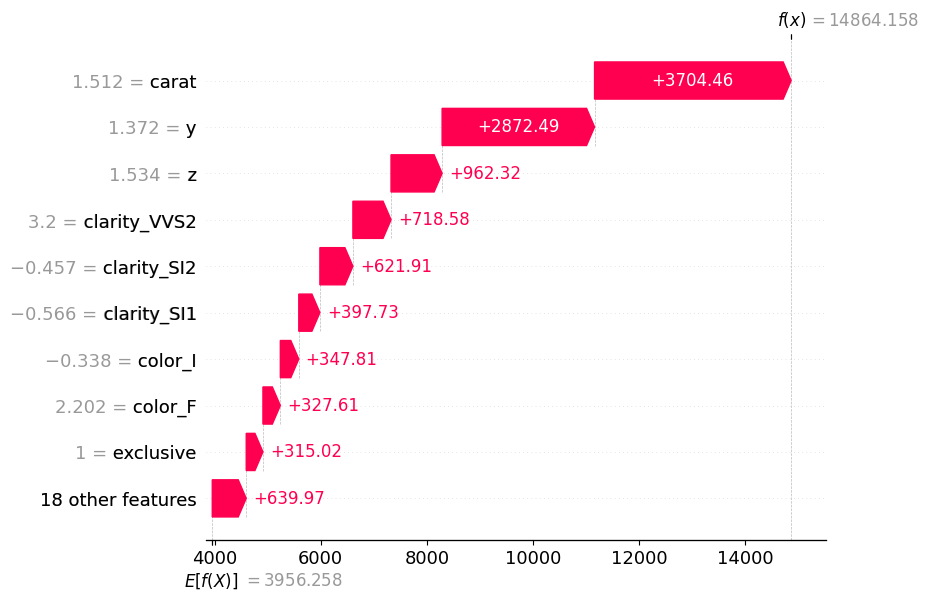

In [ ]:
# SHAP
# EXPLANATION VIA SHAP
explainer = shap.Explainer(lgbm)
print("real price:", y_test.iloc[predict_index].values)
print("prediction:", lgbm.predict(X_test.iloc[predict_index]).round(1))
shap_values = explainer(X_test.iloc[predict_index].to_frame().T)
shap.plots.waterfall(shap_values[0])